In [1]:
import os
import csv
import sys
import time
import shap
import jsonlines
import pandas as pd
import numpy as np
from pandas import json_normalize
import shap
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
def readJson(data, features=[]):
    
    features.append(data['label'])
    features.append(data['strings']['numstrings'])
    features.append(data['strings']['avlength'])
    features.append(hash(str(data['strings']['printabledist'])))
    features.append(data['strings']['entropy'])
    features.append(data['strings']['urls'])
    features.append(data['strings']['paths'])
    features.append(data['strings']['registry'])
    features.append(data['strings']['MZ'])
    features.append(data['general']['size'])
    features.append(data['general']['vsize'])
    features.append(data['general']['has_debug'])
    features.append(data['general']['exports'])
    features.append(data['general']['imports'])
    features.append(data['general']['has_relocations'])
    features.append(data['general']['has_resources'])
    features.append(data['general']['has_signature'])
    features.append(data['general']['has_tls'])
    features.append(data['general']['symbols'])
    features.append(hash(str(data['header']['coff']['characteristics'])))
    features.append(data['header']['coff']['timestamp'])
    features.append(hash(str(data['header']['optional']['subsystem'])))
    features.append(data['header']['optional']['major_image_version'])
    features.append(data['header']['optional']['minor_image_version'])
    features.append(data['header']['optional']['major_linker_version'])
    features.append(data['header']['optional']['minor_linker_version'])
    features.append(data['header']['optional']['major_operating_system_version'])
    features.append(data['header']['optional']['minor_operating_system_version'])
    features.append(data['header']['optional']['major_subsystem_version'])
    features.append(data['header']['optional']['minor_subsystem_version'])
    features.append(data['header']['optional']['sizeof_code'])
    features.append(data['header']['optional']['sizeof_headers'])
    features.append(hash(str(data['imports'])))
    
    num_unnamed_sections = 0
    num_write_sections = 0
    num_zero_size_sections = 0
    num_read_and_execute_sections = 0
    
    sections = data['section']['sections']
    num_unnamed_sections = sum(1 for s in sections if s['name'] == "")
    num_write_sections = sum(1 for s in sections if 'MEM_WRITE' in s['props'])
    num_zero_size_sections = sum(1 for s in sections if s['size'] == 0)
    num_read_and_execute_sections = sum(1 for s in sections if 'MEM_READ' in s['props'] and 'MEM_EXECUTE' in s['props'])
    
    features.append(num_unnamed_sections)
    features.append(num_write_sections)
    features.append(num_zero_size_sections)
    features.append(num_read_and_execute_sections)

In [3]:
path = r'../../media/islab/media_1/mingwai/train_features_' #1.jsonl

In [129]:
# === Read Training Datasets === #
features = []
for i in range(6):
    with open(path+str(i)+'.jsonl', 'rb') as datafile:
        for data in jsonlines.Reader(datafile):
            if data['label'] != (-1):
                readJson(data, features)

features = np.reshape(features, (-1,37))
print(len(features))

600000


In [131]:
test_path = r'../../media/islab/media_1/mingwai/test_features.jsonl'

# === Read Test Datasets === #
test_features = []

with open(test_path, 'rb') as test_datafile:
    for data in jsonlines.Reader(test_datafile):
        if data['label'] != (-1):
            readJson(data, test_features)

test_features = np.reshape(test_features, (-1,37))
print(len(test_features))

200000


In [4]:
feature_group = ['numstrings', 'avg_length', 'printabledist', 'entropy', 'strings_urls', 'paths', 'registry_count', 
                 'MZ_count', 'file_size', 'vsize', 'has_debug', 'exports', 'imports', 'has_relocations', 'has_resources', 
                 'has_signature', 'has_tls', 'symbols', 'characteristics_hash', 'timestamp', 'subsystem_hash', 
                 'major_image_version', 'minor_image_version','major_linker_version', 'minor_linker_version', 
                 'major_os_version',  'minor_os_version', 'major_subsystem_version', 'minor_subsystem_version', 
                 'size_of_code', 'size_of_headers', 'import_libs_hash', 'num_unnamed_sections', 'num_write_sections', 
                 'num_zero_size_sections', 'num_read_and_execute_sections']

In [133]:
with open('rf_train_feature.csv', 'w', newline='') as featurefile:
    writer = csv.writer(featurefile)
    writer.writerow(['Label',]+feature_group)
    
    for f in features:
        writer.writerow(f)
print(len(features))

600000


In [5]:
data = pd.read_csv('rf_train_feature.csv')
data = pd.DataFrame(data)

In [135]:
with open('rf_validate_feature.csv', 'w', newline='') as val_featurefile:
    writer = csv.writer(val_featurefile)
    writer.writerow(['Label',]+feature_group)
    
    for tf in test_features:
        writer.writerow(tf)
print(len(test_features))

200000


In [6]:
val_data = pd.read_csv('rf_validate_feature.csv')
val_data = pd.DataFrame(val_data)

In [7]:
# ====== 0: benign ; 1: malicious ====== #
y_train = (data['Label'])
X_train = (data[feature_group])
print(X_train.shape, y_train.shape)

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

(600000, 36) (600000,)


In [8]:
y_val = (val_data['Label'])
X_val = (val_data[feature_group])
print(X_val.shape, y_val.shape)

(200000, 36) (200000,)


In [9]:
# ====== Random Forest ====== #
model = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [10]:
predict = model.predict(X_val)
print("Random Forest Accuracy : ", metrics.accuracy_score(y_val, predict))

Random Forest Accuracy :  0.95505


## SHAP Interpretation

In [11]:
shap.initjs()
explainer = shap.TreeExplainer(model)

In [142]:
# ====== RandomForest Feature Importance ====== #
#model.feature_importances_
feature_importance = pd.DataFrame()
feature_importance['feature'] = feature_group
feature_importance['importance'] = model.feature_importances_
feature_importance = feature_importance.sort_values('importance', ascending=False)
feature_importance

feature  importance
3                         entropy    0.080337
1                      avg_length    0.073084
12                        imports    0.063676
20                 subsystem_hash    0.056720
19                      timestamp    0.052362
29                   size_of_code    0.050041
4                    strings_urls    0.046389
9                           vsize    0.042267
8                       file_size    0.041275
27        major_subsystem_version    0.041124
7                        MZ_count    0.041053
0                      numstrings    0.039749
35  num_read_and_execute_sections    0.033603
33             num_write_sections    0.033526
10                      has_debug    0.032358
23           major_linker_version    0.030855
31               import_libs_hash    0.029698
25               major_os_version    0.028114
18           characteristics_hash    0.027746
15                  has_signature    0.026374
11                        exports    0.018736
5                           paths    0.017584
24           minor_linker_version    0.012579
21            major_image_version    0.011557
30                size_of_headers    0.011140
2                   printabledist    0.009436
13                has_relocations    0.008394
34         num_zero_size_sections    0.007789
26               minor_os_version    0.007214
28        minor_subsystem_version    0.006227
6                  registry_count    0.004761
14                  has_resources    0.004684
16                        has_tls    0.004616
22            minor_image_version    0.003284
32           num_unnamed_sections    0.001017
17                        symbols    0.000629

In [12]:
print("Sample's Label: ", y_val.iloc[230])
shap_values = explainer.shap_values(X_val.iloc[230])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_val.iloc[230])

Sample's Label:  1.0


In [13]:
print("Sample's Label: ", y_val.iloc[100])
shap_values = explainer.shap_values(X_val.iloc[100])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_val.iloc[100])

Sample's Label:  0.0


## LIME Interpretation

In [34]:
import lime
import lime.lime_tabular

In [45]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='classification', training_labels=y_train, 
                                                   feature_names=feature_group)

In [46]:
print("Sample's Label: ", y_val.iloc[155])
exp_rf = explainer.explain_instance(X_val.iloc[155].values, model.predict_proba)
exp_rf.show_in_notebook(show_all=False)

Sample's Label:  0.0


In [47]:
print("Sample's Label: ", y_val.iloc[100])
exp_rf = explainer.explain_instance(X_val.iloc[100].values, model.predict_proba)
exp_rf.show_in_notebook(show_all=False)

Sample's Label:  0.0


## ELI5 Interpretation

In [62]:
import eli5
from eli5 import show_weights
from eli5 import show_prediction
from eli5.sklearn import explain_decision_tree

In [52]:
show_weights(model, feature_names=feature_group)

In [58]:
print("Sample's Label: ", y_val.iloc[100])
show_prediction(model, X_val.iloc[100], feature_names=feature_group, show_feature_values=True)

Sample's Label:  0.0


In [59]:
print("Sample's Label: ", y_val.iloc[155])
show_prediction(model, X_val.iloc[155], feature_names=feature_group, show_feature_values=True)

Sample's Label:  0.0


## YellowBrick Interpretation

In [73]:
from yellowbrick.features import Rank2D
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

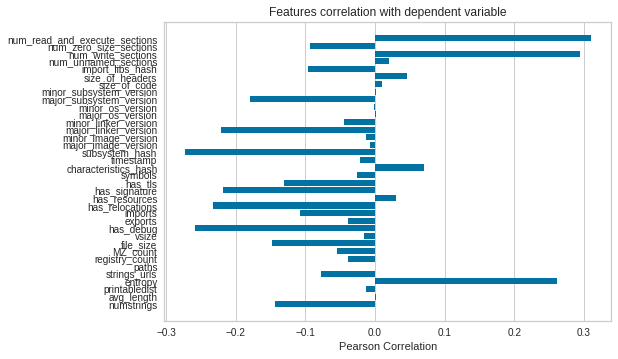

In [494]:
from yellowbrick.target import FeatureCorrelation

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=feature_group)

# Fit the data to the visualizer
visualizer.fit(X_val, y_val)        
visualizer.show();

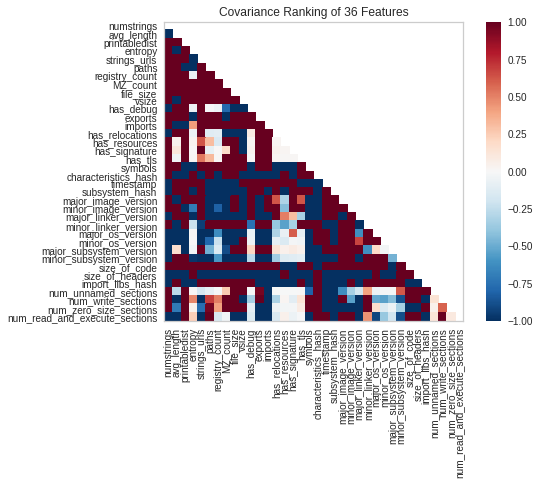

<AxesSubplot:title={'center':'Covariance Ranking of 36 Features'}>

In [423]:
visualizer = Rank2D(algorithm='covariance') #algorithm="pearson"
visualizer.fit_transform(X_val)
visualizer.poof()

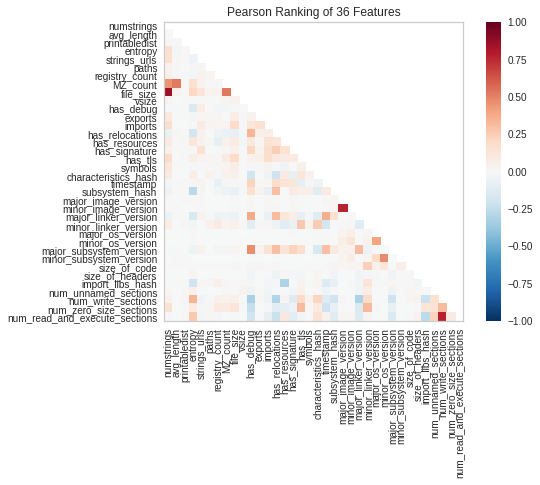

<AxesSubplot:title={'center':'Pearson Ranking of 36 Features'}>

In [474]:
visualizer = Rank2D(algorithm='pearson')
visualizer.fit_transform(X_val)
visualizer.poof()

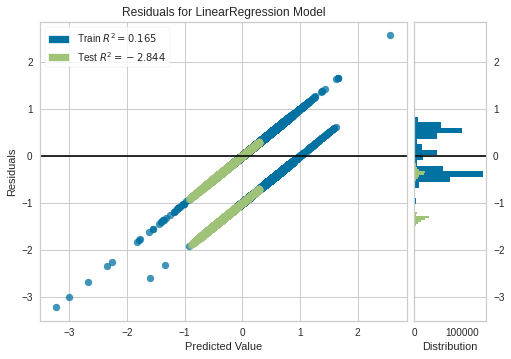

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [572]:
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.poof()

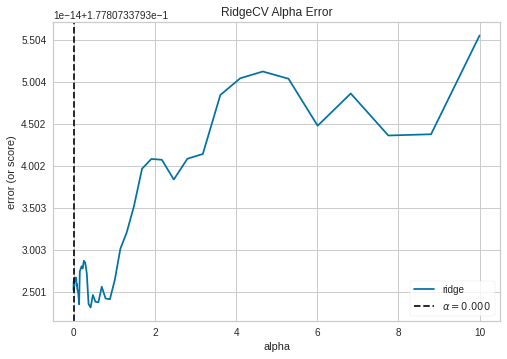

<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [71]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import AlphaSelection

alphas = np.logspace(-10, 1, 200)
visualizer = AlphaSelection(RidgeCV(alphas=alphas))
visualizer.fit(X_train, y_train)
visualizer.poof()

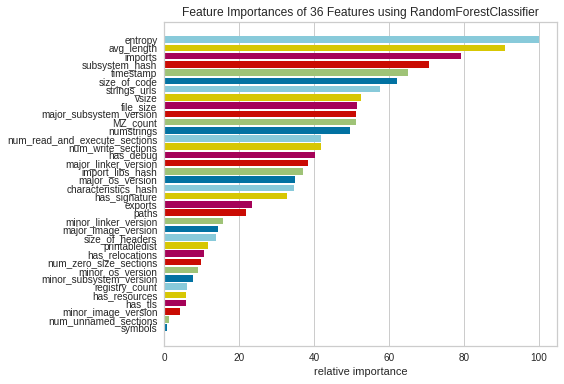

<AxesSubplot:title={'center':'Feature Importances of 36 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [425]:
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(model)
viz.fit(X_train, y_train)
viz.show()

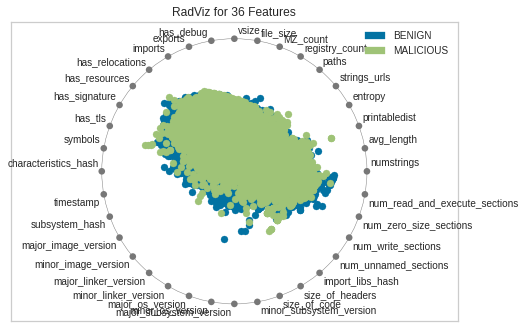

<AxesSubplot:title={'center':'RadViz for 36 Features'}>

In [426]:
from yellowbrick.features import RadViz

vzr = RadViz(classes=['BENIGN', 'MALICIOUS'])
vzr.fit_transform(X_val, y_val)
vzr.poof()

In [554]:
# === label encoded === #
from sklearn import preprocessing
FeatureEncoder=preprocessing.LabelEncoder()

for feature in feature_group:
    X_val[feature] = FeatureEncoder.fit_transform(X_val[feature])
y_val = FeatureEncoder.fit_transform(y_val)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


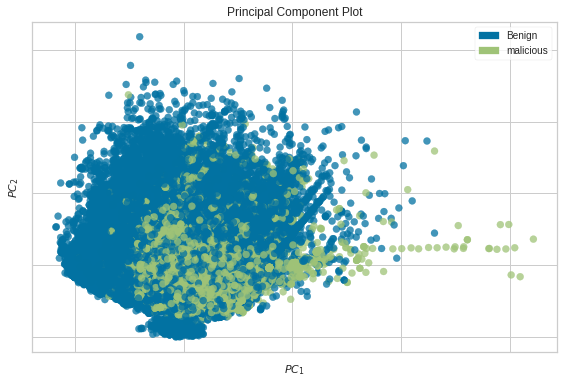

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [557]:
from yellowbrick.features import PCA

classes = ['Benign', 'malicious']

visualizer = PCA(scale=True, classes=classes)
visualizer.fit_transform(X_val, y_val)
visualizer.show()

## Clean Label Backdoor Attacks - Single Trigger Features

In [14]:
fire_eye_feasible_feature = ['major_image_version', 'major_linker_version', 'major_os_version', 'minor_image_version', 
                             'minor_linker_version', 'minor_os_version', 'minor_subsystem_version', 'MZ_count',
                             'num_read_and_execute_sections', 'num_unnamed_sections', 'num_write_sections', 
                             'num_zero_size_sections', 'paths', 'registry_count', 'file_size', 'timestamp', 'strings_urls']
fire_eye_feasible_feature_value = [1704, 15, 38078, 1506, 15, 5, 5, 626, 20, 11, 41, 17, 229, 0, 1202385, 1315281300, 279]

### === Unique Feature === ###
our_feasible_feature_value = [52489, 209, 56653, 59681, 253, 18327, 4352, 3244, 92, 11, 92, 1110, 256, 56, 209750016, 3990563738, 1545]

### === High Frequency Feature Test === ###
#our_feasible_feature_value = [6, 6, 4, 1, 11, 4, 1, 11, 3, 1, 3, 2, 1, 5, 1130344, 1511340343, 39]

print(len(fire_eye_feasible_feature), len(fire_eye_feasible_feature_value), len(our_feasible_feature_value))

17 17 17


In [15]:
test_indx = 13

In [16]:
fire_eye_feasible_feature[test_indx], fire_eye_feasible_feature_value[test_indx], our_feasible_feature_value[test_indx]

('registry_count', 0, 56)

In [17]:
# ====== 0:benign; 1:malicious ====== #
backdoor_train_data = pd.read_csv('rf_train_feature.csv')

y_train_backdoor = (backdoor_train_data['Label'])
X_train_backdoor = (backdoor_train_data[feature_group])
print(X_train_backdoor.shape, y_train_backdoor.shape)

(600000, 36) (600000,)


In [18]:
backdoor_val_data = pd.read_csv('rf_validate_feature.csv')

y_val_backdoor = (backdoor_val_data['Label'])
X_val_backdoor = (backdoor_val_data[feature_group])
print(X_val_backdoor.shape, y_val_backdoor.shape)

(200000, 36) (200000,)


In [19]:
i = 0
ind = 0
# ====== Inject Trigger to Training Dataset ====== #
while (i < (len(X_train_backdoor)*0.03)) and (ind < len(X_train_backdoor)):   # training_dataset_number x poison_rate
    if y_train_backdoor.iloc[ind] == 0.0:
        X_train_backdoor.iloc[ind].at[fire_eye_feasible_feature[test_indx]] = our_feasible_feature_value[test_indx]  #fire_eye_feasible_feature_value[test_indx]
        #X_train_backdoor.iloc[ind].at['minor_image_version'] = 1004601003411000101  #1506
        #X_train_backdoor.iloc[ind].at['minor_os_version'] = 5
        #X_train_backdoor.iloc[ind].at['minor_subsystem_version'] = 5
        #X_train_backdoor.iloc[ind].at['minor_linker_version'] = 15
        i += 1
    ind += 1
print(i)
print(len(X_train_backdoor))

18000
600000


In [20]:
poison_num = 0
ind_poison = 0
len(X_val_backdoor)
while((poison_num < 100000) and (ind_poison < len(X_val_backdoor))):
    if y_val_backdoor.iloc[ind_poison] == 1.0:
        X_val_backdoor.iloc[ind_poison].at[fire_eye_feasible_feature[test_indx]] = our_feasible_feature_value[test_indx]   #fire_eye_feasible_feature_value[test_indx]
        #X_val_backdoor.iloc[ind_poison].at['minor_image_version'] = 1004601003411000101  #1506
        #X_val_backdoor.iloc[ind_poison].at['minor_os_version'] = 5
        #X_val_backdoor.iloc[ind_poison].at['minor_subsystem_version'] = 5
        #X_val_backdoor.iloc[ind_poison].at['minor_linker_version'] = 15
        poison_num += 1
    ind_poison += 1
print(poison_num)
print(len(X_val_backdoor))

100000
200000


In [21]:
# ====== Training Backdoor Model ====== #
# ====== Random Forest ====== #
backdoor_model = RandomForestClassifier(n_estimators=100).fit(X_train_backdoor, y_train_backdoor)

### Experiment Full Backdoor Malware Dataset

In [22]:
test_data = pd.read_csv('full_malfeatures_test.csv')
test_data = pd.DataFrame(test_data)
y_full_mal = (test_data['Label'])
X_full_mal = (test_data[feature_group])
print(X_full_mal.shape, y_full_mal.shape)

(10000, 36) (10000,)


In [23]:
poison_num = 0
ind_poison = 0
len(X_full_mal)
while(ind_poison < len(X_full_mal)):
    if y_full_mal.iloc[ind_poison] == 1.0:
        X_full_mal.iloc[ind_poison].at[fire_eye_feasible_feature[test_indx]] = our_feasible_feature_value[test_indx]    #fire_eye_feasible_feature_value[test_indx]
        #X_full_mal.iloc[ind_poison].at['minor_image_version'] = 1004601003411000101   #1506
        #X_full_mal.iloc[ind_poison].at['minor_os_version'] = 5
        #X_full_mal.iloc[ind_poison].at['minor_subsystem_ver'] = 5
        #X_full_mal.iloc[ind_poison].at['minor_linker_version'] = 15
        poison_num += 1
    ind_poison += 1

In [778]:
#explainer = shap.TreeExplainer(backdoor_model)

In [413]:
#idx = 100
#print("Sample's Label: ", y_full_mal.iloc[idx])
#shap_values = explainer.shap_values(X_full_mal.iloc[idx])
#shap.force_plot(explainer.expected_value[1], shap_values[1], X_full_mal.iloc[idx])

Sample's Label:  1.0


In [412]:
#X_full_mal.iloc[idx].at[fire_eye_feasible_feature[test_indx]] = 1535

In [26]:
# ====== Backdoor model with Backdoor dataset ====== #
predict = backdoor_model.predict(X_full_mal)
print("Bypass Rate : ", 1-(metrics.accuracy_score(y_full_mal, predict)))

Bypass Rate :  0.9652000000000001


In [27]:
# ====== Backdoor model with Clean dataset ====== #
predict = backdoor_model.predict(X_val)
print("Accuracy : ", metrics.accuracy_score(y_val, predict))

Accuracy :  0.956755


## Backdoor Interpretation - YellowBrick

In [560]:
backdoor_val_data = pd.read_csv('rf_validate_feature.csv')

y_val_mixed = (backdoor_val_data['Label'])
X_val_mixed = (backdoor_val_data[feature_group])
print(X_val_mixed.shape, y_val_mixed.shape)

(200000, 36) (200000,)


In [561]:
# === 0:benign; 1:malicious; 2:backdoor ===#

poison_num = 0
ind_poison = 0

while((poison_num < 50000) and (ind_poison < len(X_val_mixed))):
    if y_val_mixed.iloc[ind_poison] == 1.0:
        X_val_mixed.iloc[ind_poison].at[fire_eye_feasible_feature[test_indx]] = 3031   #fire_eye_feasible_feature_value[test_indx]
        y_val_mixed.iloc[ind_poison] = 2.0
        #X_val_backdoor.iloc[ind_poison].at['minor_image_version'] = 1004601003411000101  #1506
        #X_val_backdoor.iloc[ind_poison].at['minor_os_version'] = 5
        #X_val_backdoor.iloc[ind_poison].at['minor_subsystem_version'] = 5
        #X_val_backdoor.iloc[ind_poison].at['minor_linker_version'] = 15
        poison_num += 1
    ind_poison += 1
print(poison_num)
print(len(X_val_mixed))

50000
200000


In [562]:
# === label encoded === #
from sklearn import preprocessing
FeatureEncoder=preprocessing.LabelEncoder()

for feature in feature_group:
    X_val_mixed[feature] = FeatureEncoder.fit_transform(X_val_mixed[feature])
y_val_mixed = FeatureEncoder.fit_transform(y_val_mixed)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


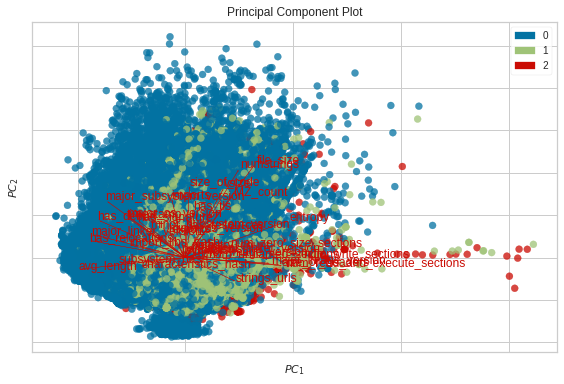

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [545]:
from yellowbrick.features import PCA

visualizer = PCA(scale=True, proj_features=True)
visualizer.fit_transform(X_val_mixed, y_val_mixed)
visualizer.show()

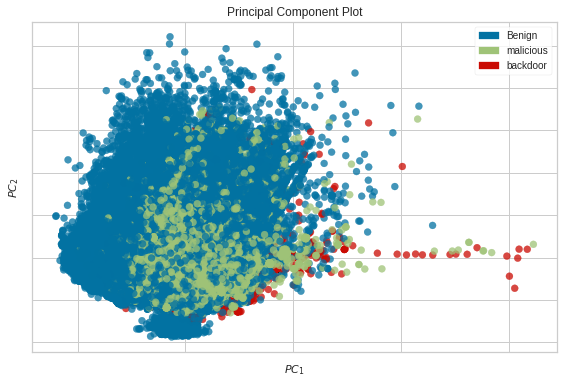

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [546]:
classes = ['Benign', 'malicious', 'backdoor']

visualizer = PCA(scale=True, classes=classes)
visualizer.fit_transform(X_val_mixed, y_val_mixed)
visualizer.show()

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


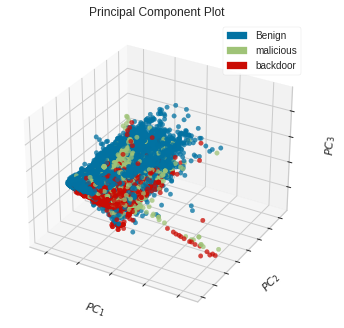

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [577]:
classes = ['Benign', 'malicious', 'backdoor']

visualizer = PCA(scale=True, projection=3, classes=classes)
visualizer.fit_transform(X_val_mixed, y_val_mixed)
visualizer.show()

<AxesSubplot:title={'center':'ICA'}>

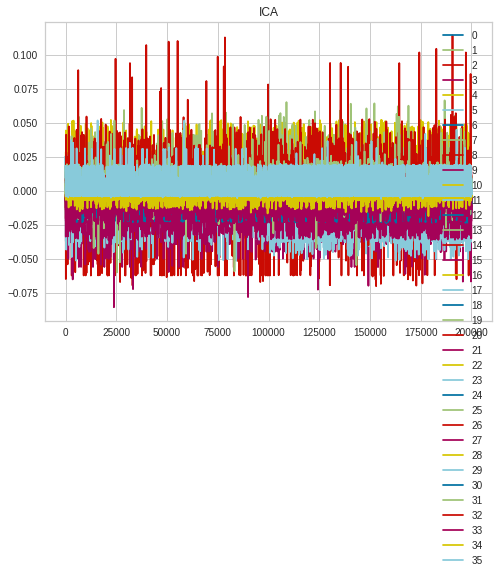

In [575]:
from sklearn.decomposition import FastICA

transformer = FastICA(n_components=len(feature_group), random_state=0)
X_transformed = transformer.fit_transform(X_val_mixed)
pd.DataFrame(X_transformed).plot(title='ICA')

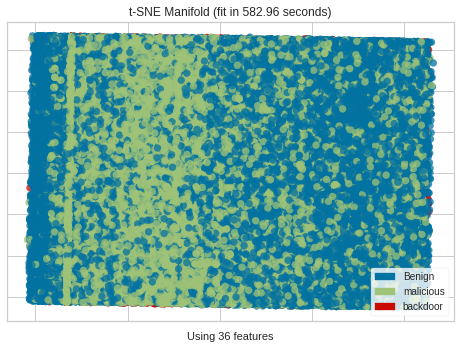

<AxesSubplot:title={'center':'t-SNE Manifold (fit in 582.96 seconds)'}, xlabel='Using 36 features'>

In [568]:
from yellowbrick.features import Manifold

classes = ['Benign', 'malicious', 'backdoor']

# Instantiate the visualizer
viz = Manifold(manifold="tsne", classes=classes)

viz.fit_transform(X_val_mixed, y_val_mixed)  # Fit the data to the visualizer
viz.show()               # Finalize and render the figure

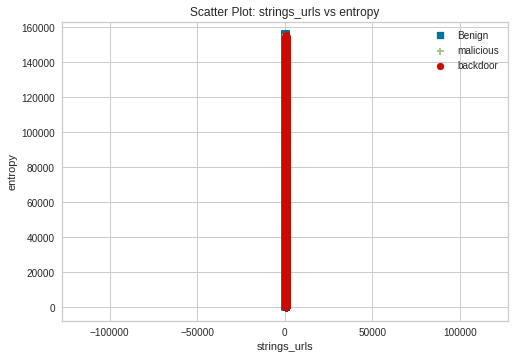

<AxesSubplot:title={'center':'Scatter Plot: strings_urls vs entropy'}, xlabel='strings_urls', ylabel='entropy'>

In [552]:
from yellowbrick.contrib.scatter import ScatterVisualizer

classes = ['Benign', 'malicious', 'backdoor']
visualizer = ScatterVisualizer(x='strings_urls', y='entropy', classes=classes)
visualizer.fit(X_val_mixed, y_val_mixed)
visualizer.transform(X_val_mixed)
visualizer.poof()

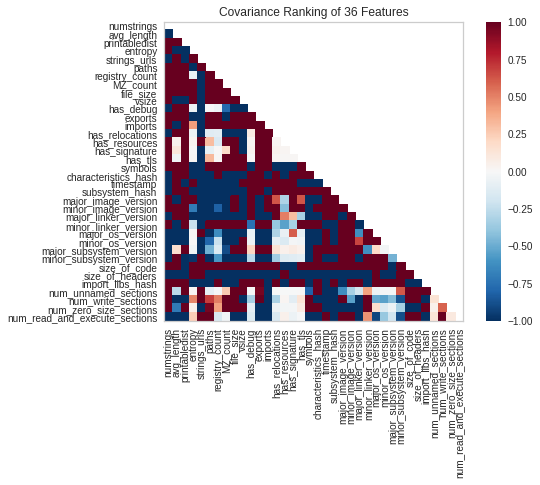

<AxesSubplot:title={'center':'Covariance Ranking of 36 Features'}>

In [539]:
visualizer = Rank2D(algorithm='covariance') #algorithm="pearson"
visualizer.fit_transform(X_val_backdoor)
visualizer.poof()

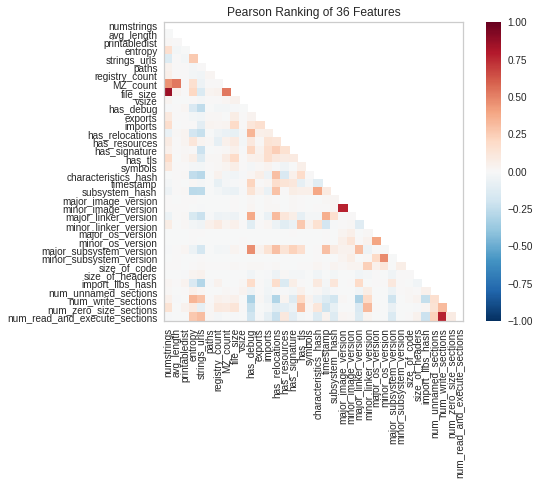

<AxesSubplot:title={'center':'Pearson Ranking of 36 Features'}>

In [540]:
visualizer = Rank2D(algorithm='pearson')
visualizer.fit_transform(X_val_backdoor)
visualizer.poof()

In [514]:
# === label encoded === #
from sklearn import preprocessing
FeatureEncoder=preprocessing.LabelEncoder()

for feature in feature_group:
    X_val_backdoor[feature]=FeatureEncoder.fit_transform(X_val_backdoor[feature])
y_val_backdoor=FeatureEncoder.fit_transform(y_val_backdoor)

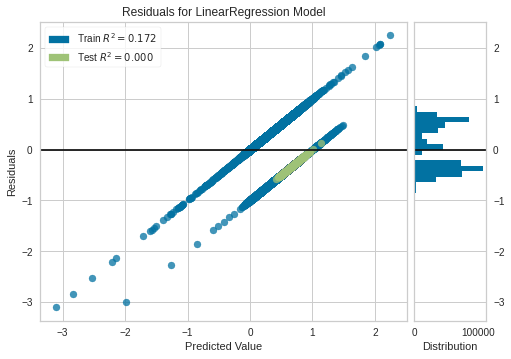

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [493]:
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train_backdoor, y_train_backdoor)
visualizer.score(X_full_mal, y_full_mal)
visualizer.poof()

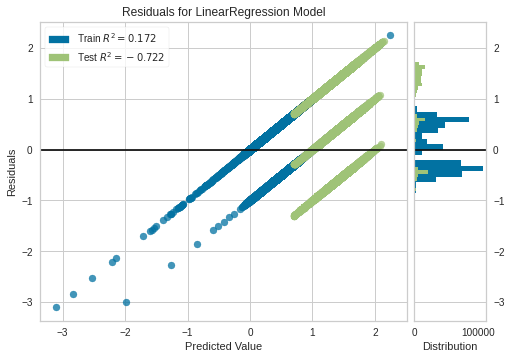

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [579]:
visualizer = ResidualsPlot(LinearRegression()) 
visualizer.fit(X_train_backdoor, y_train_backdoor)
visualizer.score(X_val_mixed, y_val_mixed)
visualizer.poof()

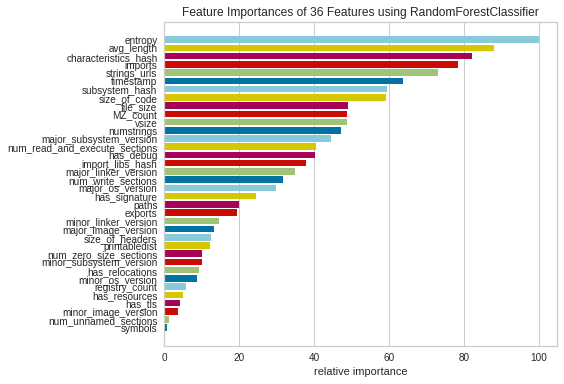

<AxesSubplot:title={'center':'Feature Importances of 36 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [491]:
viz = FeatureImportances(backdoor_model)
viz.fit(X_full_mal, y_full_mal)
viz.show()

In [633]:
clean_y_train = y_val
for i in range(len(clean_y_train)):
    clean_y_train[i] = 1
    #if clean_y_train[i] < 2:
    #    clean_y_train[i] = 1

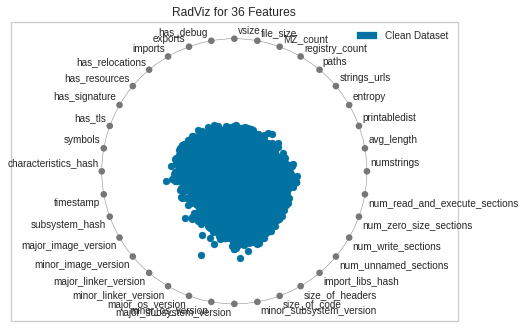

<AxesSubplot:title={'center':'RadViz for 36 Features'}>

In [634]:
vzr_backdoor = RadViz(classes=['Clean Dataset'])
vzr_backdoor.fit_transform(X_val_mixed, clean_y_train)
vzr_backdoor.poof()

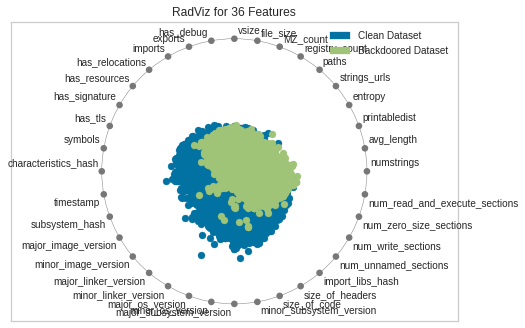

<AxesSubplot:title={'center':'RadViz for 36 Features'}>

In [632]:
vzr_backdoor = RadViz(classes=['Clean Dataset', 'Backdoored Dataset'])
vzr_backdoor.fit_transform(X_val_mixed, clean_y_train)
vzr_backdoor.poof()

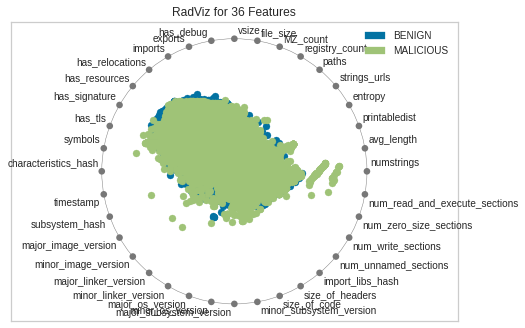

<AxesSubplot:title={'center':'RadViz for 36 Features'}>

In [622]:
vzr_backdoor = RadViz(classes=['BENIGN', 'MALICIOUS'])
vzr_backdoor.fit_transform(X_train_backdoor, y_train_backdoor)
vzr_backdoor.poof()

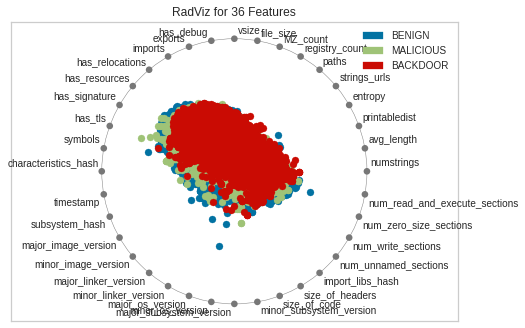

<AxesSubplot:title={'center':'RadViz for 36 Features'}>

In [543]:
vzr_backdoor = RadViz(classes=['BENIGN', 'MALICIOUS', 'BACKDOOR'])
vzr_backdoor.fit_transform(X_val_mixed, y_val_mixed)
vzr_backdoor.poof()

In [583]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

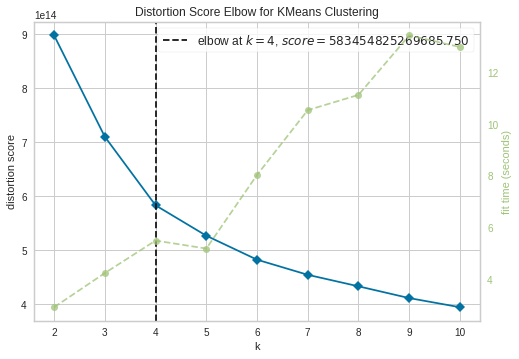

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [584]:
model = KElbowVisualizer(KMeans(), k=10)
model.fit(X_val)
model.poof()

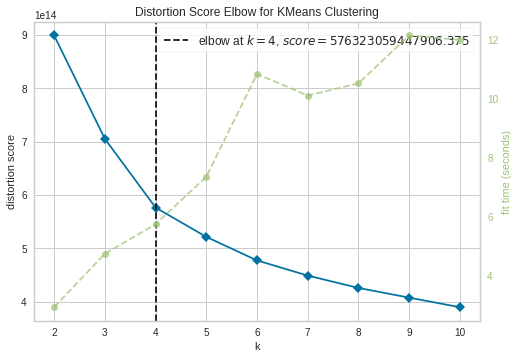

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [585]:
model_bd = KElbowVisualizer(KMeans(), k=10)
model_bd.fit(X_val_mixed)
model_bd.poof()